In [1]:
!pip install transformers
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.8 MB/s eta 0:00:00
  At

In [1]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

%matplotlib inline

In [2]:
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

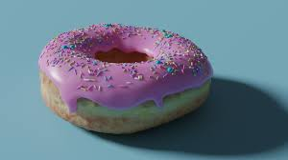

In [3]:
image = Image.open("images.jpg")
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)
image

In [4]:
inputs = feature_extractor(images=image, return_tensors="pt")

In [8]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [9]:
pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))
output

array([[1896.4113, 1899.6464, 1904.5425, ..., 2013.5996, 2007.6361,
        2002.6475],
       [1893.97  , 1897.2498, 1901.8197, ..., 2004.9691, 1999.1215,
        1994.5568],
       [1887.9728, 1891.6108, 1896.2677, ..., 1993.8995, 1988.7632,
        1985.0837],
       ...,
       [1859.455 , 1862.0621, 1864.2865, ..., 1903.8933, 1902.1843,
        1900.9724],
       [1856.221 , 1859.2351, 1861.8937, ..., 1897.2701, 1895.5547,
        1894.474 ],
       [1851.899 , 1855.169 , 1858.2036, ..., 1891.2   , 1889.7993,
        1889.1562]], dtype=float32)

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [11]:
import numpy as np
import open3d as o3d

In [12]:
width, height = image.size

depth_image = (output * 255 / np.max(output)).astype('uint8')
image = np.array(image)

In [13]:
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)


In [14]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

In [15]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd

PointCloud with 32768 points.

In [16]:
o3d.io.write_point_cloud("output_donut.ply", pcd)

True

In [17]:
# outliers removal
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0)
pcd = pcd.select_by_index(ind)

In [18]:
# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

In [19]:
# surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=12, n_threads=1)[0]

In [20]:
# rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

TriangleMesh with 71700 points and 143134 triangles.

In [21]:
# save the mesh
o3d.io.write_triangle_mesh(f'./mesh_depth12.obj', mesh)

True